# Test Time Adaptation through Evolutionary Optimised Augmentation

 Giacomo Tomezzoli (241091) &  Davide Vandelli (240207)
 <br/>**Contact:** `{giacomo.tomezzoli, davide.vandelli} [at] studenti.unitn.it`
 <br/>**Github:** `https://github.com/gzemo...`

## Abstract

Abstract section

---

## Table of contents:
1. Introduction (here the link to the section)
2. Methods
3. Results
4. Discussion
5. Conclusion
6. References


---

## Introduction
Topic introduction, literature review motivation and novelty.


## Motivation
Ideas that let us formalised a new evolutionary based approach.

---

## Methods

### Augmentation search space
(describe the search space of each possibile augmentation and state what you would like to test in the present work: optimised cropping procedure)

### Search algorithm
(try to follow the scheme of some of previous studies on the topic)




And here we will go in detail about the technical requirements, and afterwards the general experimental methods we are using.

IMPORTANT: this notebook should never be used on jupyter notebook, but only on CoLAB, because some commands for preparation will change.

In [ ]:
! pip install timm -q
! pip install cmaes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.7 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

import os
import csv
import time
import timm
import torch
import torchvision
import tarfile
import numpy as np
from PIL import Image
from cmaes import CMA
from torchvision.transforms import v2
import torchvision.transforms.functional as ttf
from scipy.stats import entropy

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
from transformers import ResNetForImageClassification

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


### General set up

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
resnet_model_name = "microsoft/resnet-50"
ViT_model_name    = "vit_base_patch16_224.augreg2_in21k_ft_in1k"
print(DEVICE)

cuda:0


In [ ]:
# INSTRUCTIONS: 1) go on Google Drive; 2) ensure that the following dataset (
#    https://drive.google.com/drive/folders/1a1-NOxfpX-IC0qMzWD9TIiBGGi6rznOb?usp=drive_link
#    ) can  be found in your Drive by adding the shared folder onto your Drive;
#    3) run this cell;  4) log in with the account you have opened the link with; 5) you're done. Celebrate if no errors appeared!
drive.mount('/content/drive')

In [ ]:
!ls /content/drive/MyDrive/Datasets

imagenet-a.tar	imagenetv2-matched-frequency.tar.gz


In [ ]:
path = '/content/drive/MyDrive/Datasets/imagenet-a.tar'
#path = '/content/drive/MyDrive/Datasets/imagenetv2-matched-frequency.tar.gz'

with tarfile.open(path, 'r') as tar:
    tar.extractall() #folder should now appear in the little files icon on the left of this Colab

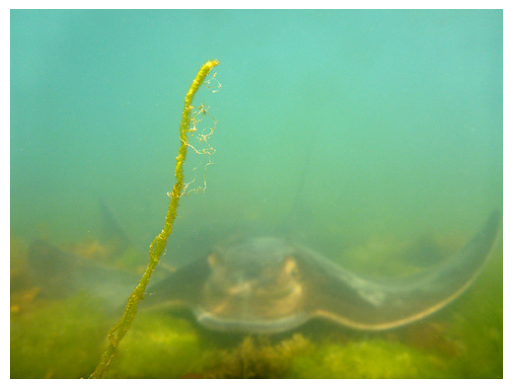

In [ ]:
image_path = '/content/imagenet-a/n01498041/0.000682_jellyfish _ jellyfish_0.99729806.jpg'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

### Backbone loading

In [ ]:
# load and explain from where you gathered the models backbone: consider the idea
# to load also RVT* by giving enough explanations about the need to pre-load the model's
# weights through the official repository.

def backbone_loading(modelname):
    """
    Pretrained visual encoder backbone loading with state dictionary.
    Returns:
        model (torch.nn.Module)
        state (torch.nn.Module.state_dict) pretrained weights
    """
    if modelname == "resnet":
        model = ResNetForImageClassification.from_pretrained(resnet_model_name).to(DEVICE)
    elif modelname == "vit":
        model = timm.create_model(ViT_model_name, pretrained=True)
    elif modelname == "rvt":
        raise NotImplementedError
    else:
        raise Exception("Choose a valid backbone model (resnet, vit, rvt)")

    model.to(DEVICE)
    state = model.state_dict()
    return model, state

In [ ]:
# example usage
model, state = backbone_loading("vit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Here some function that will rename each test dataset subfolder name

In [ ]:
# rename subfolders

### Reimplementing Memo approach
(single test data adaptation through prediction) decide whether to include also BN in a similar way (linear combination of $v_{train}$ and $v_{test}$ params).

Keep in mind that MEMO tested only over (should have tested over) an Imagenet partition: you need to reimplement that part, test with MEMO the other ImageNet partition and then hopefully improve with EvoAugmentation.

Introduce the amount of functions here presented.

In [ ]:
# define here Entropy loss:
class EntropyLoss(torch.nn.Module):

    def __init__(self, probs):
        super().__init__()
        self.probs = probs

    def forward(self):
        return (-1)*torch.sum(torch.multiply(self.probs, torch.log(self.probs)))


In [ ]:
def init_test_data_loader(image_data_folder, batch_size=1):
    """
    Test data dataLoader
    Args:
        image_data_folder: (str) path to folder  !!! check it out how it should work via Gdrive !!!
        batch_size: (int) amount of image to be put in the batch
    Return:
        torch.utils.data.DataLoader
    """
    # Resizing image and normalize according to ImageNet mean/std
    transformations = v2.Compopse([
        v2.Resize((256, 256)),   # !!! input model = (224, 224) keep it to 256 to crop it randomly !!!
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #  !!! check it out if it makes sense !!!
        ])

    # preparing DataLoader
    test_dataset = torchvision.datasets.ImageFolder(
        root = image_data_folder,
        transform = transformations,
        )

    # !!! not sure if needed !!! #
    #_, test_data = torch.utils.data.random_split(test_dataset, [0, len(test_dataset)])
    return torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8)

def init_img_augmentation():
    """
    Description
    """
    return v2.Compose([
        v2.ToTensor(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        #v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # tensor normalization [-1, 1]
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # imageNet mean normalization
        # !!! go on with other augmentation implemented as in the original paper.
    ])

def entropyLoss(probs):
    """
    Description with latex formula
    """
    # !!! (check it out for squeeze, unsqueeze)
    return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)))

def init_optimizer():
    """
    Although you're just performing a single step parameter adaptation
    you'll need to have an optimizer
    """
    return torch.optim.Adam()

def batch_norm():
    """
    Description:
    """
    raise NotImplementedError

def single_test_time_adaptation(model, state, test_image, augmenter, optimizer,
                                nAugmented=128, trainIter=1):
    """
    Perform prediction via TTA given a single test_image.
    Args:
        model: (torch.nn.Module) visual encoder backbone
        state: (torch.nn.Module.state_dict) original model params
        test_image: (torch.tensor) single DataLoader instance
        augmenter: (torchvision.transforms.v2.Compose) transform block
        optimizer:
        nAugmented: (int) amount of on-the-fly augmentation
        trainIter: (int) amount of self-supervised training steps (default: 1)
    """
    # set model as trainable if TTA is allowed
    if trainIter > 0:
        model.train()
        batch = test_image.repeat(nAugmented, 1, 1, 1)
        batch.to(DEVICE)

        for epoch in range(0, trainIter):

            # augment test image
            # !!! check if test_image.shape == (1,C,H,W) or (C,H,W)
            augm_batch = augmenter(batch)

            # Forward pass
            outputs = model(augm_batch) # .squeeze(0)
            probs = torch.softmax(outputs, -1)

            # Loss computation
            loss = entropyLoss(probs)

            # Backward pass
            loss.backward()

            # Parameters update
            optimizer.step()

            # Gradients reset
            optimizer.zero_grad()

    # "Episodic" version (updating within each single test datapoint)
    model.eval()

    with torch.no_grad():
        outputs = model(test_image) # .squeeze(0)
        probs = torch.softmax(outputs, -1)
        loss = entropyLoss(probs)

    # reset current model params
    model.load_state_dict(state)

    return probs, loss


def test(data_folder, model, state, labels, trainIter=1):
    """
    Perform all evalutation steps for each test image in the current Test set
    via Test Time Adaptation as in MEMO
    Args:
        data_folder: (str) where to look to load test data
        model: (torch.nn.Module) visual encoder backbone
        state: (torch.nn.Module.state_dict) original model params
        labels: (array) true labels
        trainIter: (int) if > 0 TTA is enabled
    Return:
        accuracy over the current dataset
        computational time
    """
    samples, cum_loss, cum_accuracy = 0., 0., 0.

    data_loader = init_test_data_loader(data_folder)

    augmenter = init_img_augmentation()
    optimizer = init_optimizer()

    t0 = time.time()
    for idx, (test_image, curr_label) in enumerate(data_loader):

        #!!! progress bar !!!

        # forward pass with TTA
        probs, loss = single_test_time_adaptation(model, state, test_image, augmenter,
                                            optimizer, nAugmented=128, trainIter=trainIter)

        # extract predicted class
        pred_class = labels[torch.argmax(probs)]

        # accuracy
        cum_accuracy += pred_class.eq(curr_label).sum().item() # !! check it ##

        # Fetch prediction and loss value
        samples += test_image.shape[0]
        cum_loss += loss.item()
        _, predicted = outputs.max(1)

    t1 = time.time()
    return cum_accuracy/samples, round(t1-t0,3)

Testing combinations of backbones and image test sets + organize in a table!!! It would be useful to have also an ablation study that shows the difference in performance both in terms of accuracy and computational time required by varying models/trainIter.

In [ ]:
def init_csv_results():
    with open("MEMOresults.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer = writerow(["dataset", "model_name", "train_iter", "accuracy", "execution_time" ])

def append_csv_results(data_folder, model_name, trainIter, accuracy, t):
    with open("MEMOresults.csv", "a", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([data_folder, model_name, trainIter, accuracy, t])

init_csv_results()

labels = # load al possible true labels
data_folder = #
for model_name in ["resnet", "vit", "rvt"]: # decide either to take or remove
    model, state = backbone_loading(model_name)
    for trainIter in range(1, 3):
        accuracy, t = test(data_folder, model, state, labels, trainIter=trainIter)
        append_csv_results(data_folder, model_name, trainIter, accuracy, t)


# image modification function to be
# torchvision.transforms.functional.crop

In [ ]:
net = backbone_loading()
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

In [ ]:
#help(net.load_state_dict)
net.load_state_dict(net.state_dict())

<All keys matched successfully>

### Testing Entropy Map

In this section the Entropyh map will be addressed by implementing a custom pooling layer that will be used in order to preprocess the test image to be further optimise the evolutionary process.

In [ ]:
def entropy_pooling(img, k=3, fun=entropy):
    """
    Perform same padding entropy pooling by convoluting a kernel of size k
    (and stride=1) over the imput image

    args:
        img: (Pil.Image) image in grayscale
        k: (int) kernel size
        fun: function to apply (default: scipy.stats.entropy)

    return torch.Tensor
    """
    assert k % 2 != 0, "Kernel size must be an even number."

    # tensor conversion (!!! remove it !!!)
    img = ttf.to_tensor(img) if not isinstance(img, torch.Tensor) else img

    h, w = img.shape[1:]

    # adding the channel dimension (bachsize, nchannel, H, W)
    img = img.reshape(1, 1, h, w)

    img = ttf.pad(img, tuple([(k-1)//2]*4), padding_mode='edge')

    # unfolding
    folds = img.unfold(2,k,1).unfold(3,k,1).transpose(1,3).reshape(-1, 1, k, k)

    # Entropy pooling: applying the input function to each image sub-fold
    e_pooling = torch.tensor(list(map(fun, [folds[i, 0, :, :].flatten() for i in range(folds.shape[0])])))

    # folding back
    pooled = torch.reshape(e_pooling, (h,w)).transpose(-1,0).unsqueeze(0)

    return pooled

In [ ]:
## Emergency un-efficient pooling operation
#k = 3
#e, s = np.zeros((224-k, 224-k)), np.zeros((224-k, 224-k))
#for i in range(0, 224-k):
#    for j in range(0, 224-k):
#        tmp = img[0, i:i+k, j:j+k].flatten()
#        e[i,j] = entropy(tmp)
#        s[i,j] = tmp.std()

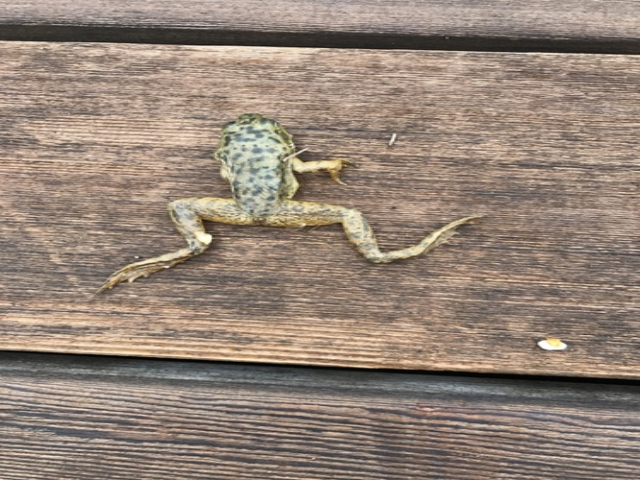

In [ ]:
# showing the image
filename = "frog.jpg"
ttf.resize(Image.open(filename).convert('RGB'), (480,640))

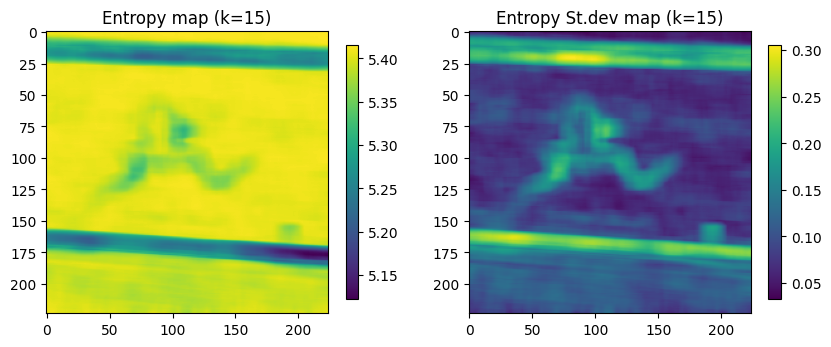

In [ ]:
imagename = "frog.jpg"
img = ttf.to_tensor(Image.open(imagename).convert("L").resize((224,224)))

# visual displaying
k = 15
fig, axs = plt.subplots(1, 2, figsize=(10,6))
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        mat = ax.imshow(entropy_pooling(img, k=k, fun=entropy)[0,:,:])
        ax.set_title(f"Entropy map (k={k})")
    else:
        mat = ax.imshow(entropy_pooling(img, k=k, fun=torch.std)[0,:,:])
        ax.set_title(f"Entropy St.dev map (k={k})")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.show()

In [ ]:
# precompute the entropy map for a grid of kernel sizes
tosave = dict()
ks = [3, 7, 11, 21, 31]
for k in ks:
    e = entropy_pooling(img, k=k, fun=entropy)
    s = entropy_pooling(img, k=k, fun=torch.std)
    tosave[k] = (e,s)

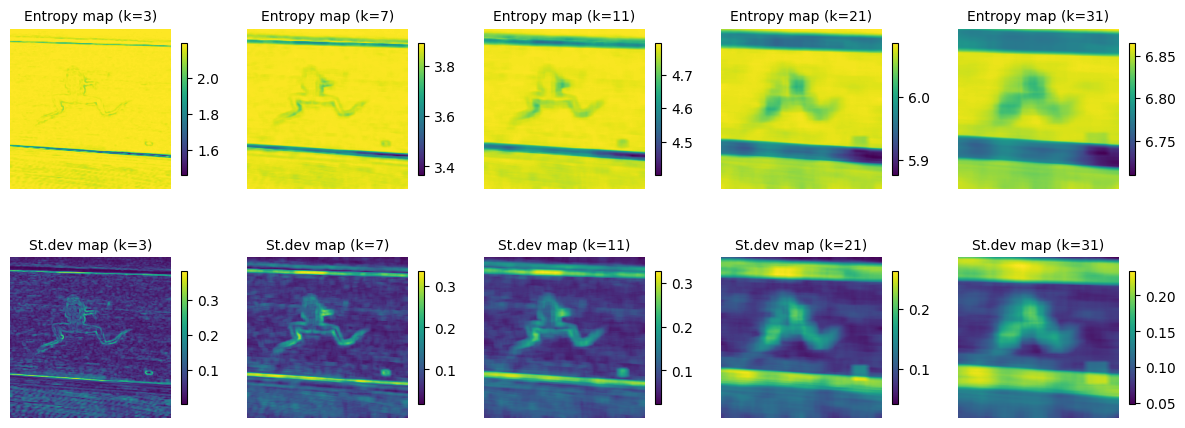

In [ ]:
# plot
fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mat = ax.imshow(tosave[ks[i]][0][0,:,:])
        ax.set_title(f"Entropy map (k={ks[i]})", fontsize=10)

    else:
        mat = ax.imshow(tosave[ks[i-5]][1][0,:,:])
        ax.set_title(f"St.dev map (k={ks[i-5]})", fontsize=10)

    ax.axis("off")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.tight_layout()
plt.show()

In [ ]:
# example from  https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work
x = torch.arange(36).float()

# squared kernel size
k = 5

# reshaping
x2d = x.reshape(1,1,6,6)

# number of channel
c = x2d.size(1)

# padding
padding = tuple([(k-1)//2]*4)
x2d = ttf.pad(x2d, padding, fill=0, padding_mode='constant' )
r = x2d.unfold(2,k,1).unfold(3,k,1).transpose(1,3).reshape(-1, c, k, k)
print(r)

re = torch.tensor(list((map(torch.max, [r[i, 0, :, :].flatten() for i in range(r.shape[0])]))))
re = torch.reshape(re, (6,6)).transpose(-1,0)
print(re)


### CMA-ES
*(Covariance Matrix Adaptation - Evolutionary Strategy)*


In [ ]:
# example usage
def quadratic(x1, x2):
    #return (x1 - 3) ** 2 + (10 * (x2 + 2)) ** 2
    return (x1**2) + (x2**2)

optimizer = CMA(mean=np.zeros(2), sigma=1.3, population_size = 10) # initialise the instance

for generation in range(50):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask() # sample a new solution given the current opt step
        value = quadratic(x[0], x[1]) # evaluate the solution through the fitness function
        solutions.append((x, value))
        print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})") # save the best solution for each gen
    print("-"*80)
    optimizer.tell(solutions)

print(optimizer.population_size)

In [ ]:
class CropInstance():
	"""
	Normalised Crop instance
	"""
	def __init__(self, x:float, y:float, w:float, h:float, imgsize:tuple):
		assert 0 <= x < 1 and 0 <= y < 1, "Cropping point out of bound!"
		assert 0 <= w < 1 and 0 <= h < 1, "Bounding dimension out of bound!"

		self.x, self.y = x, y
		self.imgsize = imgsize
		self.xlim = self.ylim = 1
		self.w_min = self.h_min = 1/6 # or even 1/5
		self.toint = False

		# check for min/max bounds
		self.w = w if w > self.w_min else self.w_min
		self.w = self.xlim - self.x if self.x + self.w > self.xlim else self.w
		self.h = h if h > self.h_min else self.h_min
		self.h = self.ylim - self.y if self.y + self.h > self.ylim else self.h

		# final check: consider to delete this section
		assert self.x + self.w <= self.xlim, "Cropping bounding box out of bound! (x axis)"
		assert self.y + self.h <= self.ylim, "Cropping bounding box of bound! (y axis)"

		# integer conversion
		self.xint, self.yint, self.wint, self.hint = tuple(
			map(round,
			    [self.x * self.imgsize[0],
				 self.y * self.imgsize[1],
				 self.w * self.imgsize[0],
				 self.h * self.imgsize[1]]) # need to reverse the 0,1 since is (h,w) and not (w,h)
   		)
	def __str__(self):
		return f"{(self.x, self.y, self.w, self.h)}"

In [ ]:
# example with just 2 dimension
optimizer2d = CMA(mean = np.array([0.5, 0.5]), # centering the mean over the center of the normalised image
                  sigma = 0.2, # initial sigma
                  bounds = np.array([(0,1), (0,1)]),
                  seed = 123) # bounding the search over (0,1) limits in each direction

# Optimizer obj for 3 dim bounding box (x,y,l)
optimizer3d = CMA(mean = np.array([0.5, 0.5, 0.2]), # mean of (x,y,l)
                  sigma = 0.2,
                  bounds = np.array([(0,1), (0,1), (0,1)]),
                  seed = 123)

# Optimizer obj for 4 dim bounding box (x,y,w,h)
optimizer4d = CMA(mean = np.array([0.5, 0.5, 0.5, 0.5]), # mean of (x,y,w,h)
                  sigma = 0.2,
                  bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                  population_size = 15,
                  seed = 123)

Here the complete CMA-ES block evolving cropping regions is implemented

In [ ]:
def fitness1(model, batch):
    """
    Compute entropy of the cropped images organised in batch (n_item, c, w, h)
    """
    batch = batch.to(DEVICE)
    with torch.no_grad():
        outputs = model(batch) # .squeeze(0)
        probs   = torch.softmax(outputs, -1)
        re = (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)
        return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

def fitness2(phenotype, alpha=1000):
    """
    Compute the fitness of a cropped entropy map
    """
    #return (-1) * (phenotype.std() / (alpha*(phenotype.shape[0]*phenotype.shape[1])))
    #return (-1) * (phenotype.std() + (alpha*(phenotype.shape[0]*phenotype.shape[1])))
    #return (-1) * phenotype.std()
    return phenotype.mean()

def resize_crop(img, x, y, w, h, target_dim):
    """
    Return the unsqueeze cropped and resized image converted into tensor
    """
    if target_dim != None:
        res = ttf.to_tensor(ttf.crop(img, y, x, h, w).resize(target_dim)).unsqueeze(0)
    else:
        res = ttf.crop(img, y, x, h, w).unsqueeze(0)
    return res

def update_cache(cache, generation, value, cand_bb):
    """
    Update the optimization performance logs
    """
    cache["best_fit"][generation]   = torch.min(value).item()
    cache["avg_fit"][generation]    = torch.mean(value).item()
    cache["std_fit"][generation]    = torch.std(value).item()
    cache["median_fit"][generation] = torch.median(value).item()
    cache["worst_fit"][generation]  = torch.max(value).item()
    cache["cand_solutions"].append(cand_bb)
    cache["best_solutions"].append(cand_bb[torch.argmin(value).item()])
    return cache

def plot_performance(cache, Ntrials):
    """
    Plot fitness values along generations
    """
    plt.figure(figsize=(10,5))
    plt.plot(cache["best_fit"], color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["worst_fit"], color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["median_fit"], color="black", label="median", linewidth=1.15, alpha=0.3)
    plt.plot(cache["avg_fit"], color="blue", label="avg", linewidth=1.15)
    plt.plot(cache["avg_fit"]+cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.plot(cache["avg_fit"]-cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.fill_between(range(0, Ntrials), cache["avg_fit"]+cache["std_fit"], cache["avg_fit"]-cache["std_fit"], alpha=0.1)
    plt.suptitle("CMA-ES performance")
    #plt.ylim((0,cache["worst_fit"].max().item()))
    plt.ylabel("Entropy")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_crop_results(cache, img, Ntrials):
    """
    Plot Cropping regions according to generations
    """
    gens = [1] + list(range(10,Ntrials+1,10))
    fig, axs = plt.subplots(3, 3, figsize=(15,10))
    fig.suptitle("Cropping regions over generations")
    im = np.asarray(img)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(im)
        for cbb in cache["cand_solutions"][gens[i]-1]:
            ax.add_patch(
                patches.Rectangle((cbb.xint, cbb.yint),
                                   cbb.wint, cbb.hint,
                                   linewidth=0.9,
                                   edgecolor='r',
                                   facecolor='none'))
        ax.axis("off")
        ax.set_title(f"Gen: {gens[i]}")
    plt.show()



def main(imgfilename, mode, Ntrials, popSize, kernel_size, seed):
    """
    Perform augmentation search in order to crop portions of the original test
    image by minimising the objective according to 'mode'.
    Args:
        imgfilename: (str) image filepath
        mode: (str) optimisation procedure allowed: ('model', 'emap')
        Ntrials: (int) amount of evolutionary steps
        popsize: (int) amount of instances to evolve
        kernel_size: (int) size of the entropy pooling (for 'emap' only)
        seed: (int) random seed
    return:
        cache: (dict) performance log
    """
    # test image loading
    if mode == "model":
        img = ttf.resize(Image.open(imgfilename).convert('RGB'), (224, 224))

    elif mode == "emap":
        img = ttf.to_tensor(ttf.resize(Image.open(imgfilename).convert('L'), (224, 224)))
        entropy_map = entropy_pooling(img, k=kernel_size, fun=entropy)

    # initialise the optimizer
    optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]), # mean of (x,y,w,h)
                     sigma = 0.1,
                     bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                     population_size = popSize,
                     seed = seed,
                     lr_adapt=True)

    # initialise cache to store evolutionary performance
    cache = {"best_fit":np.zeros((Ntrials)),
             "avg_fit":np.zeros((Ntrials)),
             "std_fit":np.zeros((Ntrials)),
             "median_fit":np.zeros((Ntrials)),
             "worst_fit":np.zeros((Ntrials)),
             "cand_solutions":[],
             "best_solutions":[]}

    for generation in range(Ntrials):

        # draw the current generation sample
        sample = [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

        # convert each candidate solution into a CropInstance bounding box
        cand_bb = [CropInstance(s[0], s[1], s[2], s[3], (224,224)) for s in sample]

        # fist attempt with model entropy
        if mode == "model":
            phenotype = [resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, (224,224)) for cbb in cand_bb]
            batch  = torch.cat(phenotype, 0)
            value  = fitness1(model, batch)

        # second attempt with entropy map
        elif mode == "emap":
            phenotype = [resize_crop(entropy_map, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None) for cbb in cand_bb]
            value = torch.tensor([fitness2(instance).item() for instance in phenotype])

        # eval and draw new solutions
        solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
        optimizer4d.tell(solutions)

        # update cache
        cache = update_cache(cache, generation, value, cand_bb)

        # log
        if (generation+1) % 10 == 0 or generation == 0:
            print(f"gen: {generation+1:3d}/{Ntrials}  -  best: {cache['best_fit'][generation]:.6f}  -  avg: {cache['avg_fit'][generation]:.6f} ")

    # displaying results
    plot_performance(cache, Ntrials)

    if mode == "model":
        show_crop_results(cache, img, Ntrials)
    elif mode == "emap":
        show_crop_results(cache, entropy_map[0,:,:], Ntrials)

    return cache

Testing both approaches (**model guided** crop search and **entropy map minimisation**)

In [ ]:
# flipping side (just for testing purpose)
hf = torchvision.transforms.RandomHorizontalFlip(p=1)
flipped_img = hf(img)

gen:   1/80  -  best: 1.369658  -  avg: 2.308779 
gen:  10/80  -  best: 1.537414  -  avg: 1.979998 
gen:  20/80  -  best: 1.278352  -  avg: 1.604907 
gen:  30/80  -  best: 1.270562  -  avg: 1.565846 
gen:  40/80  -  best: 1.279292  -  avg: 1.497096 
gen:  50/80  -  best: 1.389091  -  avg: 1.589053 
gen:  60/80  -  best: 1.254846  -  avg: 1.541072 
gen:  70/80  -  best: 1.301102  -  avg: 1.565157 
gen:  80/80  -  best: 1.259467  -  avg: 1.578778 


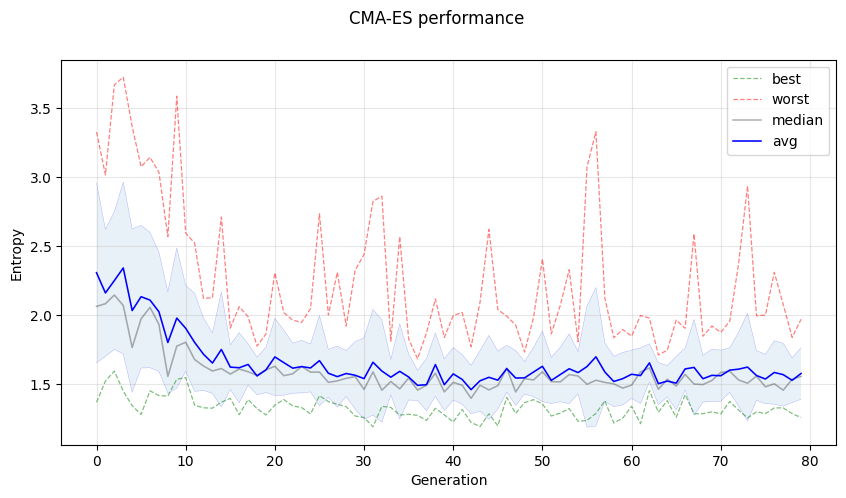

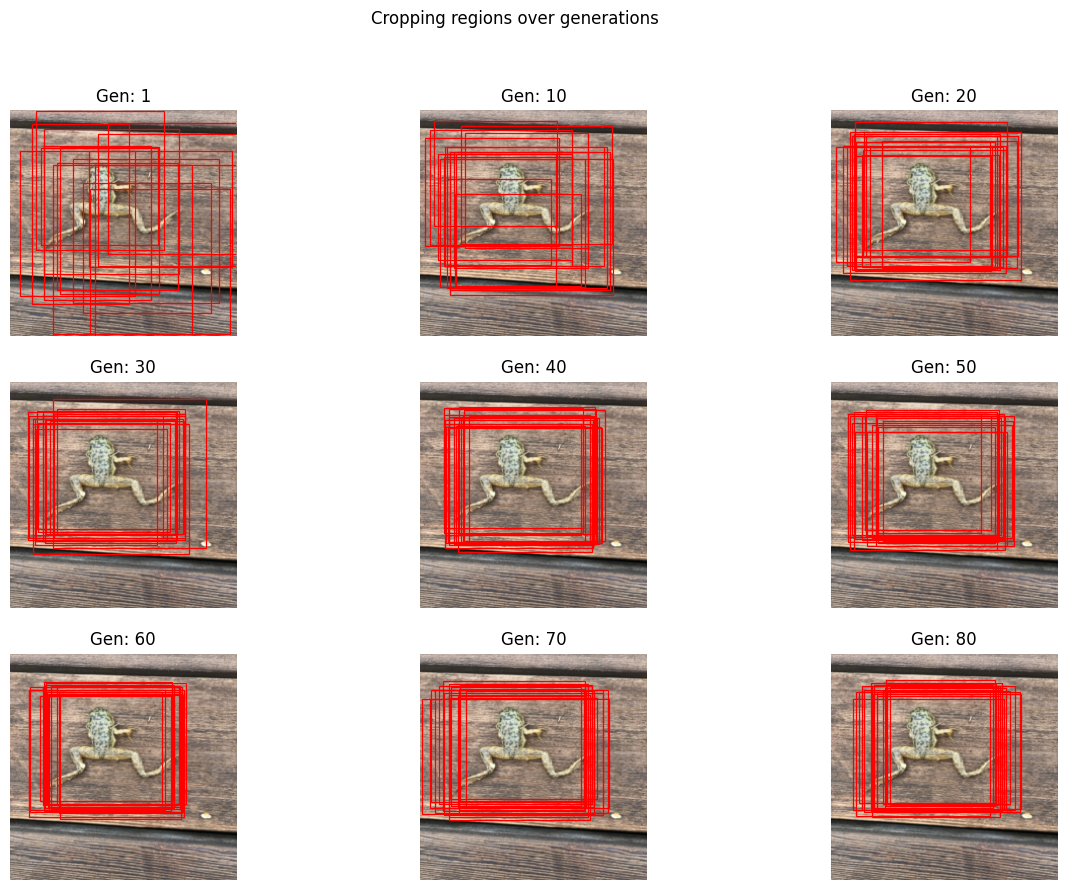

In [ ]:
filename = "frog.jpg"
mode = "model" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

gen:   1/80  -  best: 4.762952  -  avg: 4.770444 
gen:  10/80  -  best: 4.738779  -  avg: 4.763460 
gen:  20/80  -  best: 4.738455  -  avg: 4.756435 
gen:  30/80  -  best: 4.731261  -  avg: 4.755051 
gen:  40/80  -  best: 4.696522  -  avg: 4.748294 
gen:  50/80  -  best: 4.694490  -  avg: 4.725952 
gen:  60/80  -  best: 4.694393  -  avg: 4.720287 
gen:  70/80  -  best: 4.695490  -  avg: 4.722240 
gen:  80/80  -  best: 4.693547  -  avg: 4.702336 


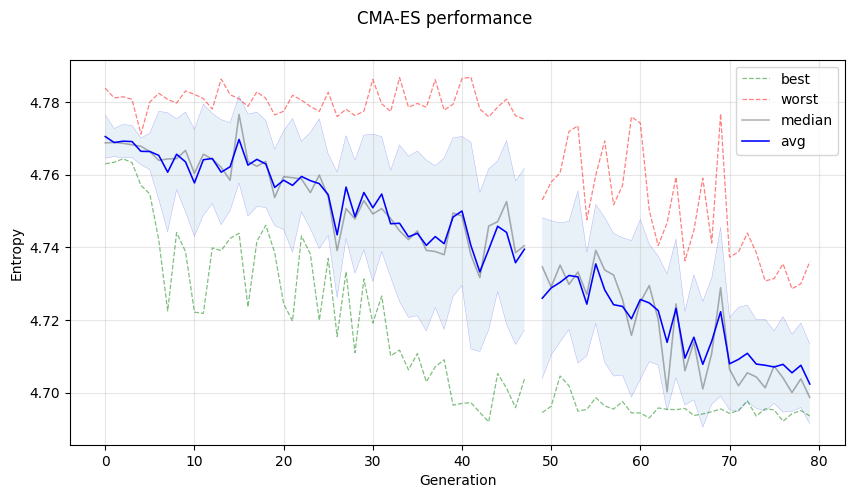

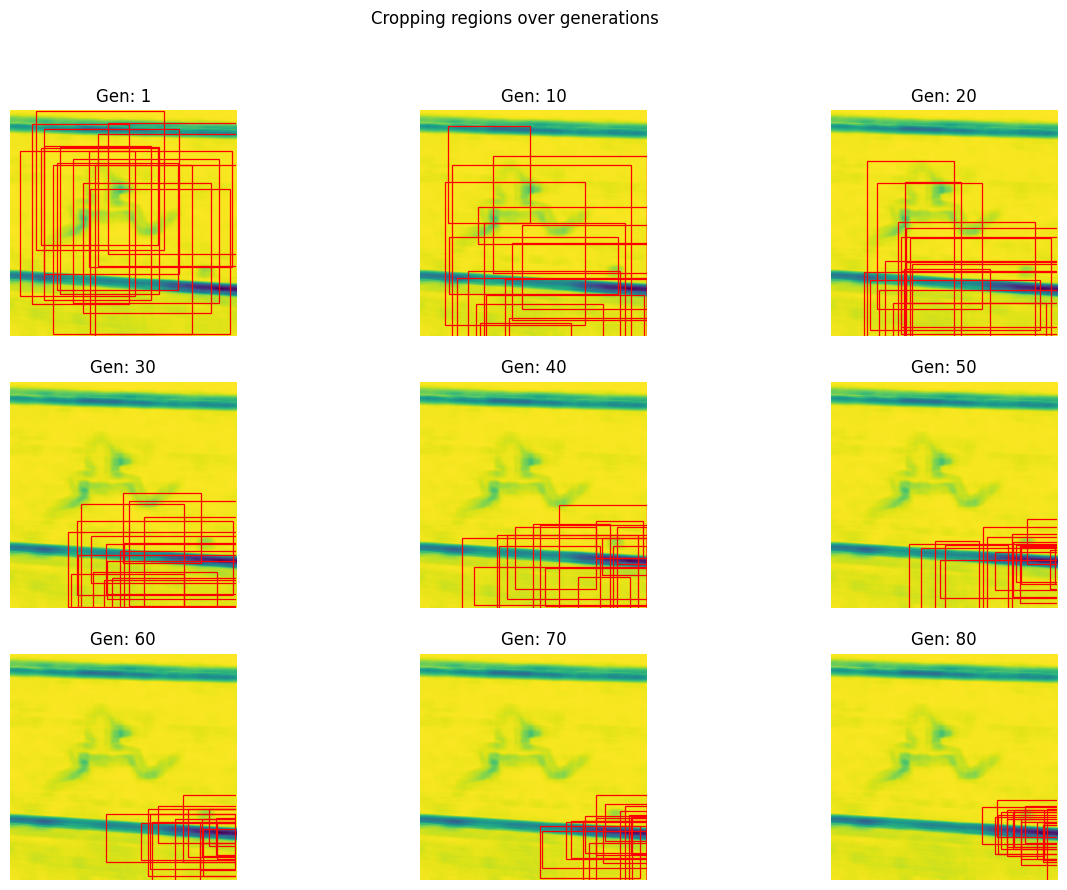

In [ ]:
filename = "frog.jpg"
mode = "emap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

gen:   1/80  -  best: 0.911387  -  avg: 1.600665 
gen:  10/80  -  best: 0.852607  -  avg: 1.710887 
gen:  20/80  -  best: 0.899110  -  avg: 1.409351 
gen:  30/80  -  best: 0.682600  -  avg: 1.810713 
gen:  40/80  -  best: 0.858392  -  avg: 1.091501 
gen:  50/80  -  best: 0.904506  -  avg: 1.036922 
gen:  60/80  -  best: 0.877864  -  avg: 1.039161 
gen:  70/80  -  best: 0.964504  -  avg: 1.048841 
gen:  80/80  -  best: 0.819920  -  avg: 1.024733 


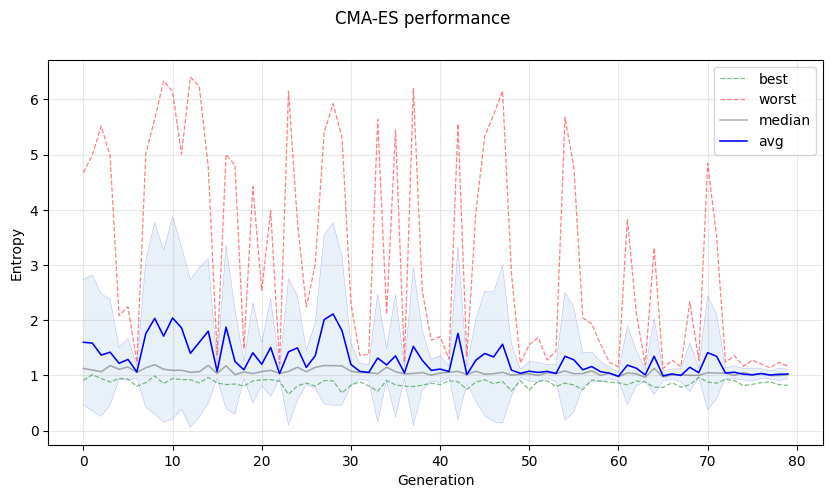

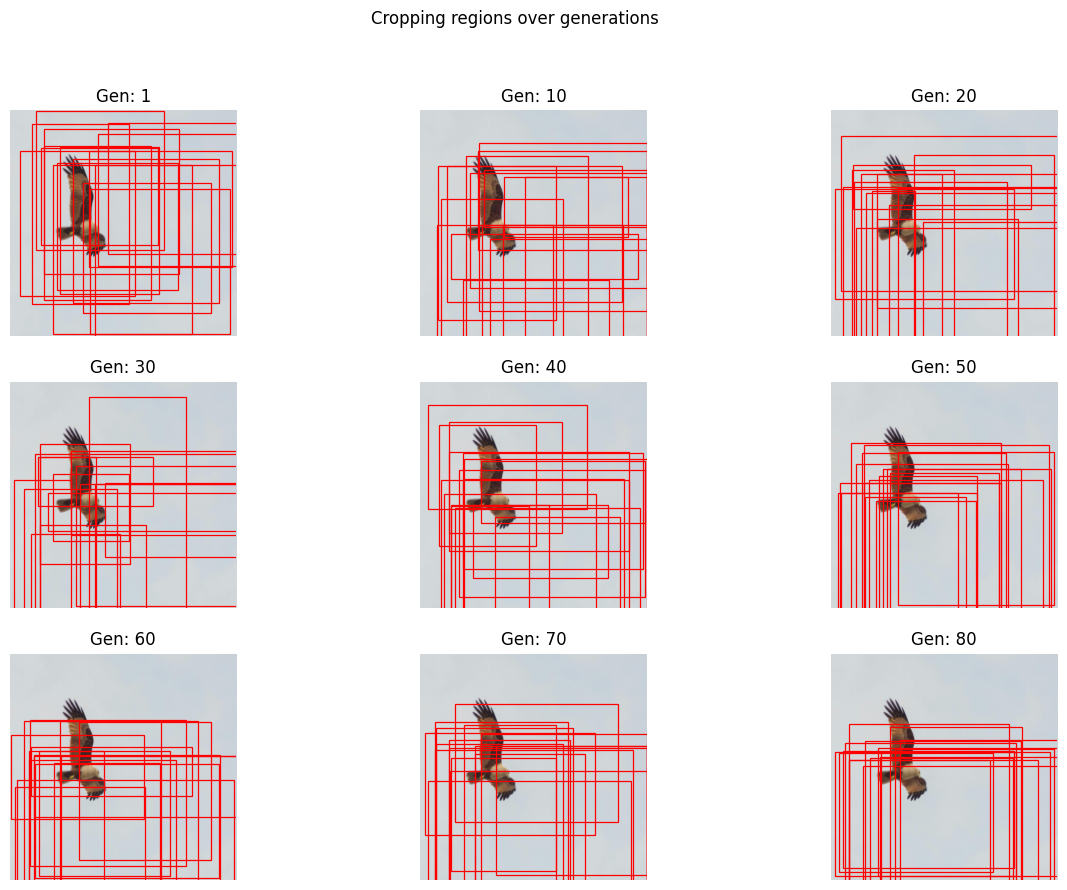

In [ ]:
filename = "hawk.jpg"
mode = "model" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

gen:   1/80  -  best: 4.773455  -  avg: 4.784568 
gen:  10/80  -  best: 4.753471  -  avg: 4.768706 
gen:  20/80  -  best: 4.721592  -  avg: 4.737706 
gen:  30/80  -  best: 4.716126  -  avg: 4.724973 
gen:  40/80  -  best: 4.714849  -  avg: 4.719531 
gen:  50/80  -  best: 4.714793  -  avg: 4.716120 
gen:  60/80  -  best: 4.714496  -  avg: 4.714865 
gen:  70/80  -  best: 4.714496  -  avg: 4.714901 
gen:  80/80  -  best: 4.714496  -  avg: 4.714629 


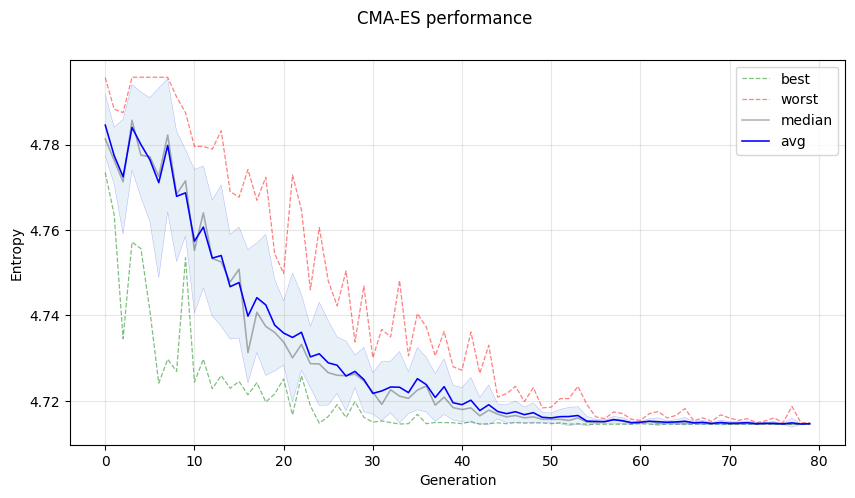

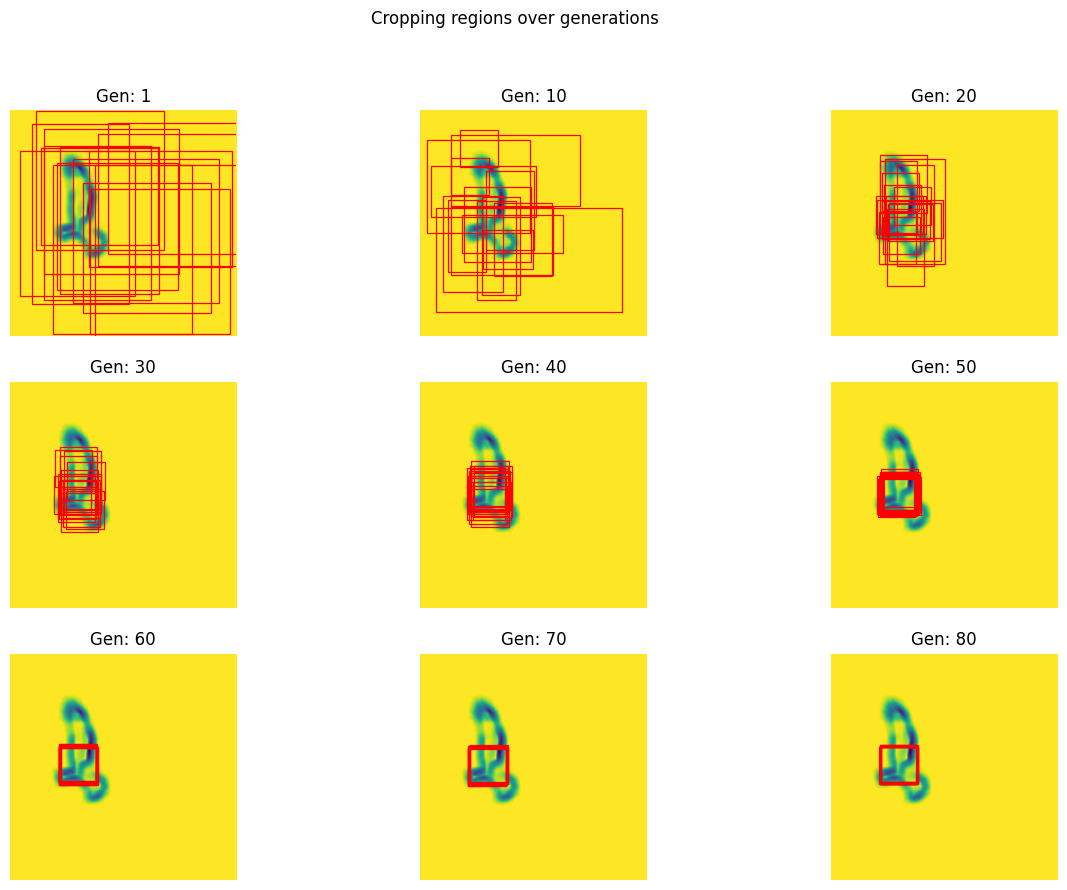

In [ ]:
filename = "hawk.jpg"
mode = "emap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

Displaying where the cropping regions coordinates had been converged according to a given `generation`.


Some notes:
apparently the mean initialisation seems not to influence the final convergence given sufficient instances to explore the space for a reasonable amount of generations. Some parameters are still needed to be tuned. The entropy minimum reached by the search algorithm is not corresponding to the perfectly cropped image subject. We may hope to rely on few optimisation evolutionary runs in order to get some original test image cropped areas to be used as prediction.
We can also try to classify each test image according to the resulting candidates over $N$ generations

Some solution from image high frequency processing ?

In [ ]:
# run cma-es on the entropy map according to some kernel size and collect the candidate solution over a limited set of cropping instances.
# collapse them in a batch, perform a model feedforward pass and collect the avg prediction.
# update model params by estimating the entropy of the current predictions.
# run a new instance of cma-es changing the seed (new intialization, allowing the process to stocastically improve)
# update model params ...
# run a new instance ...
# prediction
# model reset





In [ ]:
ttf.to_tensor(img).shape


torch.Size([1, 224, 224])

In [ ]:
type(img)

torch.Tensor